<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png"
    style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="colr:black">Miniproject 2 - Processing and analysis of EMG data</h1>
<h1 style="colr:black">Part 2</h1>
<h4 style="white-space: nowrap">Camille Dorster, Toufan Kashaev, Johan Bordet</h4>

### Imports and preprocessing functions

In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import butter, sosfiltfilt
from scipy.ndimage import convolve1d
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
import seaborn as sns
import os

np.random.seed(42)
random_state = 42

# NinaPro DB1 EMG sampling freq
fs = 100  # Hz

def bandpass_emg(emg, fs, bp=(5, 45)):
    sos_bp = butter(N=4, Wn=bp, fs=fs, btype="bandpass", output="sos")
    return sosfiltfilt(sos_bp, emg.T).T

def rectified_envelope(emg_filt, window_samples=25):
    emg_rect = np.abs(emg_filt)
    w = np.ones(window_samples) / window_samples
    return convolve1d(emg_rect, w, axis=0, mode="nearest")

def get_epochs(emg_env, stimulus, repetition, min_len=5):
    classes = np.unique(stimulus)
    classes = classes[classes != 0]        # remove rest
    reps = np.unique(repetition)
    reps = reps[reps != 0]                 # remove 0

    epochs, labels = [], []
    for c in classes:
        for r in reps:
            idx = np.logical_and(stimulus == c, repetition == r)
            if not np.any(idx):
                continue
            epoch = emg_env[idx, :]
            if epoch.shape[0] < min_len:
                continue
            epochs.append(epoch)
            labels.append(int(c))
    return epochs, np.array(labels)

def build_dataset_from_epochs(epochs, labels, feature_fns):
    n_samples = len(epochs)
    n_channels = epochs[0].shape[1]
    n_feat = len(feature_fns)

    X = np.zeros((n_samples, n_channels * n_feat))
    for i, ep in enumerate(epochs):
        blocks = [f(ep) for f in feature_fns]   # each (n_channels,)
        X[i, :] = np.stack(blocks, axis=0).reshape(-1)
    return X, labels.copy()

In [2]:
# --- features (5 per channel) ---
def mav(x): return np.mean(np.abs(x), axis=0)
def rms(x): return np.sqrt(np.mean(x**2, axis=0))
def var_feature(x): return np.var(x, axis=0)
def wl(x): return np.sum(np.abs(np.diff(x, axis=0)), axis=0)
def zc(x, threshold=1e-6):
    # NOTE: on rectified/envelope signals ZC often has low utility; kept for consistency with your request
    x1, x2 = x[:-1, :], x[1:, :]
    crossings = (x1 * x2) < 0
    amp_diff = np.abs(x2 - x1) > threshold
    return np.sum(crossings & amp_diff, axis=0)

feature_fns = [mav, rms, var_feature, wl, zc]

## 1. Visualize & preprocess

In [3]:
verbose = False
data_folder_name = "Data"

# Only keep directories (subjects)
subject_folders = sorted([
    folder for folder in os.listdir(data_folder_name)
    if os.path.isdir(os.path.join(data_folder_name, folder))
])

subjects = {}  # store per-subject processed data + (optional) per-subject feature matrix

for folder in subject_folders:
    folder_path = os.path.join(data_folder_name, folder)

    # Prefer A1_E1 if present, otherwise any *E1.mat
    mat_files_a1e1 = [f for f in os.listdir(folder_path) if f.lower().endswith("a1_e1.mat")]
    if mat_files_a1e1:
        mat_file = sorted(mat_files_a1e1)[0]
    else:
        mat_files_e1 = [f for f in os.listdir(folder_path) if f.lower().endswith("e1.mat")]
        if not mat_files_e1:
            if verbose:
                print(f"No E1 file found in {folder_path}, skipping.")
            continue
        mat_file = sorted(mat_files_e1)[0]

    path = os.path.join(folder_path, mat_file)
    data = loadmat(path)

    # Variables (consistent with Part 1)
    if "emg" not in data or "restimulus" not in data or "rerepetition" not in data:
        print(f"[WARN] Missing expected keys in {path}. Found keys: {list(data.keys())}")
        continue

    emg = data["emg"]                          # (T, n_channels)
    stimulus = data["restimulus"].ravel()      # (T,)
    repetition = data["rerepetition"].ravel()  # (T,)

    if verbose:
        print(f"\nSubject folder: {folder} | File: {mat_file}")
        print("EMG shape:", emg.shape)
        print("Stimulus labels:", np.unique(stimulus))
        print("Repetition ids:", np.unique(repetition))

    # --- Part 1 preprocessing ---
    emg_filt = bandpass_emg(emg, fs, bp=(5, 45))
    emg_env = rectified_envelope(emg_filt, window_samples=25)

    # --- Part 1 epoching ---
    epochs, labels = get_epochs(emg_env, stimulus, repetition, min_len=5)

    if len(epochs) == 0:
        print(f"[WARN] No valid epochs extracted for {folder} ({mat_file}), skipping.")
        continue

    # --- Feature extraction (one sample per epoch) ---
    X_sub, y_sub = build_dataset_from_epochs(epochs, labels, feature_fns)

    # store per-subject
    subjects[folder] = {
        "file": mat_file,
        "emg": emg,
        "stimulus": stimulus,
        "repetition": repetition,
        "emg_env": emg_env,
        "epochs": epochs,
        "labels": labels,
        "X": X_sub,
        "y": y_sub,
        "n_epochs": len(epochs),
        "n_channels": emg.shape[1],
        "feature_dim": X_sub.shape[1],
    }

print(f"Loaded {len(subjects)} subjects.")
if len(subjects) > 0:
    first_key = next(iter(subjects.keys()))
    print("Example subject:", first_key, "X shape:", subjects[first_key]["X"].shape)

Loaded 27 subjects.
Example subject: s1 X shape: (120, 50)


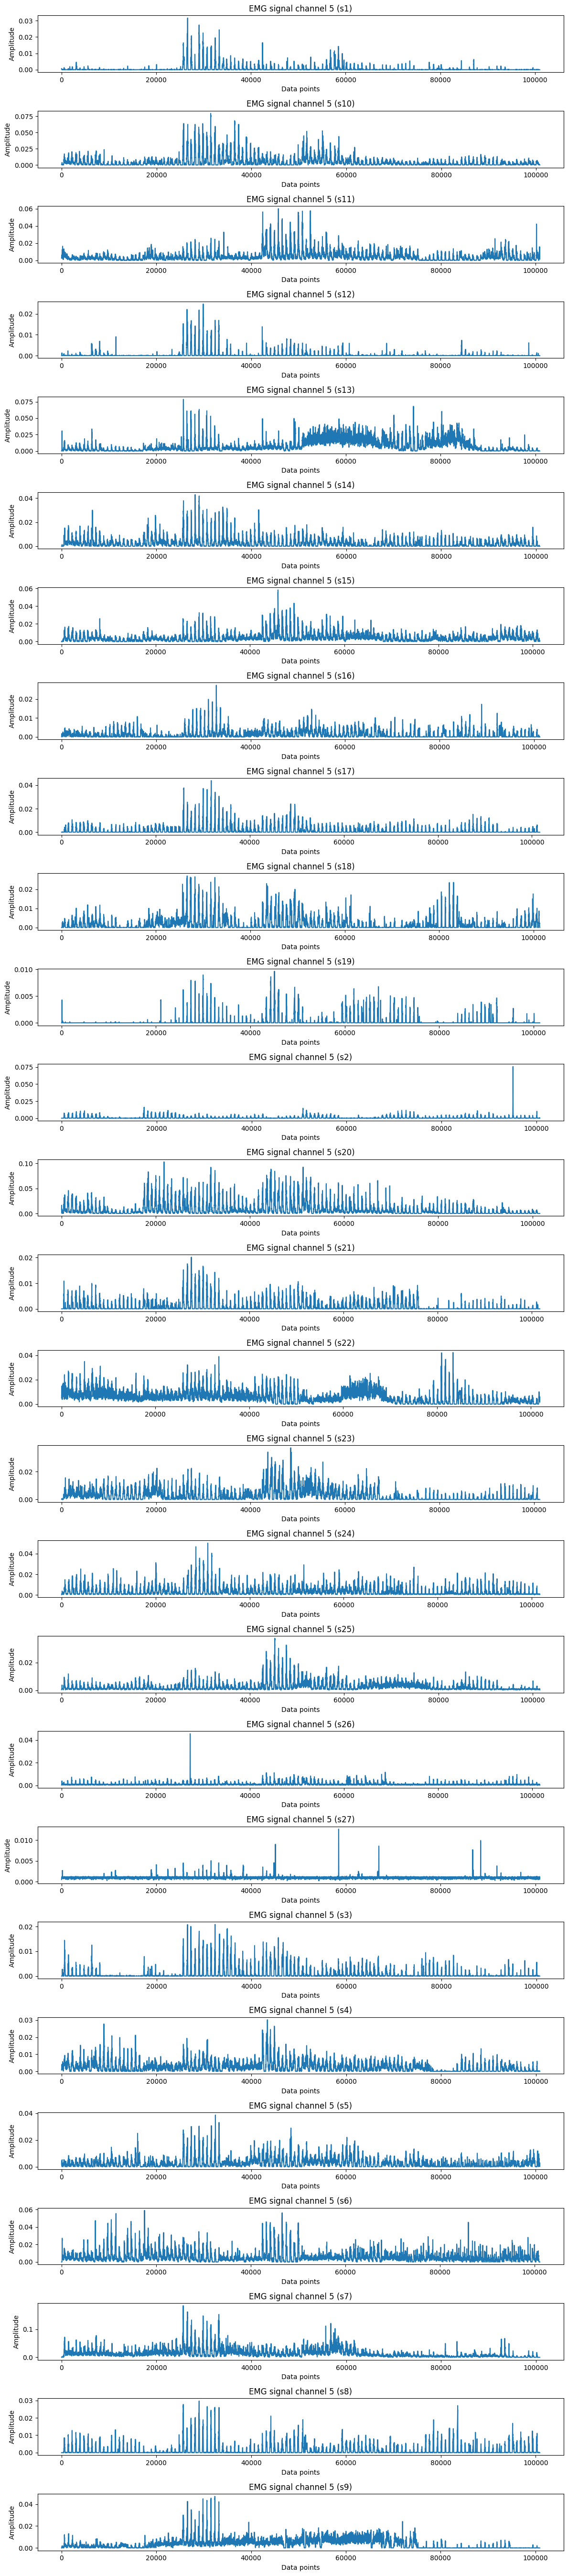

In [4]:
import matplotlib.pyplot as plt
#plot first EMG channel for all 27 subjects
plt.close('all')
fig, axes = plt.subplots(len(subjects), 1, figsize=(12, 2*len(subjects)))

for idx, (fname, sub) in enumerate(subjects.items()):
    emg = sub['emg_env']
    EMG_channel = 5 if emg.shape[1] > 5 else 0
    axes[idx].plot(emg[:, EMG_channel])
    axes[idx].set_title(f"EMG signal channel {EMG_channel} ({fname})")
    axes[idx].set_xlabel('Data points')
    axes[idx].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

## 2. Feature extraction & visualization

In [5]:
subject_datasets = {}

for fname, sub in subjects.items():
    if "X" not in sub or "y" not in sub or sub["X"] is None:
        print(f"[WARN] {fname}: missing X/y, skipping.")
        continue

    X = sub["X"]
    y = sub["y"].astype(int)

    print(f"{fname}: X {X.shape}, y {y.shape}, classes {np.unique(y)}")
    subject_datasets[fname] = {"dataset": X, "labels": y}


s1: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s10: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s11: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s12: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s13: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s14: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s15: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s16: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s17: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s18: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s19: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s2: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s20: X (120, 50), y (120,), classes [ 1  2  3  4  5  6  7  8  9 10 11 12]
s21: X (120, 50), y (120,), classes [ 1 

## 4. Gradient boosting classification

#### Aggregate data across subjects (X_all, y_all, groups)

In [6]:
X_list, y_list, groups_list = [], [], []

# subject_datasets keys should be like "s1", "s2", ... or similar
for fname, data_pair in subject_datasets.items():
    X = data_pair["dataset"]
    y = data_pair["labels"]

    # Parse integer subject id from folder name (e.g., "s27" -> 27)
    subj_id = int("".join([ch for ch in fname if ch.isdigit()]))

    X_list.append(X)
    y_list.append(y)
    groups_list.append(np.full(len(y), subj_id, dtype=int))

X_all = np.vstack(X_list)
y_all = np.concatenate(y_list).astype(int)
groups = np.concatenate(groups_list)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)
print("groups shape:", groups.shape)
print("Subjects present:", np.unique(groups))

X_all shape: (3240, 50)
y_all shape: (3240,)
groups shape: (3240,)
Subjects present: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


### Subject-wise split: train subjects 1..26, test subject 27

In [7]:
train_subjects = np.arange(1, 27)   # 1..26
test_subjects = np.array([27])

train_mask = np.isin(groups, train_subjects)
test_mask  = np.isin(groups, test_subjects)

X_train_final = X_all[train_mask]
y_train_final = y_all[train_mask]
groups_train  = groups[train_mask]

X_test_final  = X_all[test_mask]
y_test_final  = y_all[test_mask]

print("Train:", X_train_final.shape, y_train_final.shape, "Subjects:", np.unique(groups_train))
print("Test :", X_test_final.shape, y_test_final.shape, "Subjects:", np.unique(groups[test_mask]))

# Safety checks
assert X_train_final.shape[0] == y_train_final.shape[0]
assert X_test_final.shape[0] == y_test_final.shape[0]

Train: (3120, 50) (3120,) Subjects: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Test : (120, 50) (120,) Subjects: [27]


### Standardization (fit train only)

In [8]:
scaler = StandardScaler()
X_train_z = scaler.fit_transform(X_train_final)
X_test_z  = scaler.transform(X_test_final)

### Train and evaluate baseline Gradient Boosting

In [9]:
gb = GradientBoostingClassifier(random_state=0)

print("\nTraining Gradient Boosting...")
gb.fit(X_train_z, y_train_final)

y_test_pred = gb.predict(X_test_z)

test_accuracy = accuracy_score(y_test_final, y_test_pred)
test_f1_macro = f1_score(y_test_final, y_test_pred, average="macro")

print("\n--- FINAL EVALUATION (TEST: subject 27) ---")
print(f"Baseline test accuracy:  {test_accuracy:.4f}")
print(f"Baseline test macro-F1:  {test_f1_macro:.4f}")


Training Gradient Boosting...

--- FINAL EVALUATION (TEST: subject 27) ---
Baseline test accuracy:  0.1583
Baseline test macro-F1:  0.1205


### Group-aware cross-validation on training subjects

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingClassifier(random_state=0))
])

gkf = GroupKFold(n_splits=5)

cv_scores = cross_val_score(
    pipe,
    X_train_final, y_train_final,
    cv=gkf,
    groups=groups_train,
    scoring="accuracy"
)

print("GroupKFold CV accuracy per fold:", cv_scores)
print("Mean GroupKFold CV accuracy:", cv_scores.mean())


## Rotation of test subject across all 27 subjects

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingClassifier(random_state=0))
])

logo = LeaveOneGroupOut()

loso_scores_acc = cross_val_score(
    pipe, X_all, y_all,
    cv=logo,
    groups=groups,
    scoring="accuracy"
)

loso_scores_f1 = cross_val_score(
    pipe, X_all, y_all,
    cv=logo,
    groups=groups,
    scoring="f1_macro"
)

print("LOSO accuracy mean ± std:", loso_scores_acc.mean(), loso_scores_acc.std())
print("LOSO macro-F1 mean ± std:", loso_scores_f1.mean(), loso_scores_f1.std())


Accuracy scores for each fold: [0.285      0.29666667 0.215      0.32333333 0.28      ]
Mean accuracy for each fold: 0.27999999999999997


## Varying the number of training subjects

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("gb", GradientBoostingClassifier(random_state=0))
])

test_subj = 27
train_order = [s for s in np.unique(groups) if s != test_subj]  # 1..26 if present

X_test = X_all[groups == test_subj]
y_test = y_all[groups == test_subj]

accs, f1s, ks = [], [], []

for k in range(1, len(train_order) + 1):
    train_subjs = train_order[:k]
    train_mask = np.isin(groups, train_subjs)

    X_tr = X_all[train_mask]
    y_tr = y_all[train_mask]

    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred, average="macro"))
    ks.append(k)

print("k subjects -> last acc, f1:", ks[-1], accs[-1], f1s[-1])
